In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
#train function and stock the acc values in the lists
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # create lists to store the results for each epoch of the trained model
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return [model,val_acc]

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Normalized

In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [37]:
torch.cuda.empty_cache()

In [38]:
Normal_model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/9
----------
train Loss: 0.0055 Acc: 0.9992
val Loss: 0.1365 Acc: 0.9700

Epoch 1/9
----------
train Loss: 0.0054 Acc: 0.9991
val Loss: 0.1333 Acc: 0.9711

Epoch 2/9
----------
train Loss: 0.0066 Acc: 0.9982
val Loss: 0.1424 Acc: 0.9693

Epoch 3/9
----------
train Loss: 0.0053 Acc: 0.9992
val Loss: 0.1413 Acc: 0.9711

Epoch 4/9
----------
train Loss: 0.0055 Acc: 0.9991
val Loss: 0.1413 Acc: 0.9700

Epoch 5/9
----------
train Loss: 0.0053 Acc: 0.9989
val Loss: 0.1388 Acc: 0.9693

Epoch 6/9
----------
train Loss: 0.0058 Acc: 0.9988
val Loss: 0.1385 Acc: 0.9696

Epoch 7/9
----------
train Loss: 0.0061 Acc: 0.9989
val Loss: 0.1410 Acc: 0.9689

Epoch 8/9
----------
train Loss: 0.0053 Acc: 0.9987
val Loss: 0.1382 Acc: 0.9696

Epoch 9/9
----------
train Loss: 0.0055 Acc: 0.9992
val Loss: 0.1390 Acc: 0.9686

Training complete in 11m 41s
Best val Acc: 0.971071


### Gaussian Blur effect

In [4]:
Gaussian_Blur = torchvision.transforms.GaussianBlur(kernel_size=9, sigma=3)

In [5]:
# Data augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        Gaussian_Blur
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        Gaussian_Blur
    ]),
}

data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [6]:
torch.cuda.empty_cache()

In [7]:
Blurry_model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/9
----------


C:\Users\thoma\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.4500 Acc: 0.8563
val Loss: 0.2428 Acc: 0.9139

Epoch 1/9
----------
train Loss: 0.1882 Acc: 0.9355
val Loss: 0.2107 Acc: 0.9329

Epoch 2/9
----------
train Loss: 0.1368 Acc: 0.9549
val Loss: 0.1208 Acc: 0.9568

Epoch 3/9
----------
train Loss: 0.1031 Acc: 0.9654
val Loss: 0.1240 Acc: 0.9550

Epoch 4/9
----------
train Loss: 0.0776 Acc: 0.9734
val Loss: 0.1773 Acc: 0.9514

Epoch 5/9
----------
train Loss: 0.0599 Acc: 0.9799
val Loss: 0.1371 Acc: 0.9579

Epoch 6/9
----------
train Loss: 0.0426 Acc: 0.9867
val Loss: 0.1289 Acc: 0.9600

Epoch 7/9
----------
train Loss: 0.0196 Acc: 0.9943
val Loss: 0.1207 Acc: 0.9696

Epoch 8/9
----------
train Loss: 0.0128 Acc: 0.9965
val Loss: 0.1284 Acc: 0.9679

Epoch 9/9
----------
train Loss: 0.0106 Acc: 0.9974
val Loss: 0.1321 Acc: 0.9704

Training complete in 18m 6s
Best val Acc: 0.970357


### Contrast effect

In [8]:
class AdjustContrastTransform:
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, image):
        return transforms.functional.to_tensor(transforms.functional.adjust_contrast(image, self.factor))

In [9]:
# Data augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        AdjustContrastTransform(factor=2)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        AdjustContrastTransform(factor=2)
    ]),
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [10]:
torch.cuda.empty_cache()

In [11]:
Constrasted_model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/9
----------
train Loss: 0.0086 Acc: 0.9980
val Loss: 0.1334 Acc: 0.9704

Epoch 1/9
----------
train Loss: 0.0074 Acc: 0.9987
val Loss: 0.1345 Acc: 0.9704

Epoch 2/9
----------
train Loss: 0.0069 Acc: 0.9986
val Loss: 0.1375 Acc: 0.9693

Epoch 3/9
----------
train Loss: 0.0087 Acc: 0.9982
val Loss: 0.1389 Acc: 0.9679

Epoch 4/9
----------
train Loss: 0.0058 Acc: 0.9990
val Loss: 0.1383 Acc: 0.9696

Epoch 5/9
----------
train Loss: 0.0064 Acc: 0.9986
val Loss: 0.1344 Acc: 0.9704

Epoch 6/9
----------
train Loss: 0.0062 Acc: 0.9985
val Loss: 0.1375 Acc: 0.9696

Epoch 7/9
----------
train Loss: 0.0061 Acc: 0.9985
val Loss: 0.1396 Acc: 0.9700

Epoch 8/9
----------
train Loss: 0.0065 Acc: 0.9987
val Loss: 0.1383 Acc: 0.9693

Epoch 9/9
----------
train Loss: 0.0062 Acc: 0.9984
val Loss: 0.1400 Acc: 0.9707

Training complete in 11m 40s
Best val Acc: 0.970714


### Rotated Effect

In [12]:
Rotater = torchvision.transforms.RandomRotation(degrees=(0, 180))

In [13]:
# Data augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        Rotater
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        Rotater
    ]),
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [14]:
torch.cuda.empty_cache()

In [15]:
Rotated_model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/9
----------
train Loss: 0.0056 Acc: 0.9990
val Loss: 0.1401 Acc: 0.9704

Epoch 1/9
----------
train Loss: 0.0058 Acc: 0.9988
val Loss: 0.1407 Acc: 0.9693

Epoch 2/9
----------
train Loss: 0.0062 Acc: 0.9989
val Loss: 0.1370 Acc: 0.9693

Epoch 3/9
----------
train Loss: 0.0060 Acc: 0.9988
val Loss: 0.1368 Acc: 0.9707

Epoch 4/9
----------
train Loss: 0.0051 Acc: 0.9994
val Loss: 0.1403 Acc: 0.9693

Epoch 5/9
----------
train Loss: 0.0053 Acc: 0.9990
val Loss: 0.1386 Acc: 0.9700

Epoch 6/9
----------
train Loss: 0.0059 Acc: 0.9988
val Loss: 0.1405 Acc: 0.9707

Epoch 7/9
----------
train Loss: 0.0054 Acc: 0.9990
val Loss: 0.1340 Acc: 0.9686

Epoch 8/9
----------
train Loss: 0.0056 Acc: 0.9990
val Loss: 0.1431 Acc: 0.9707

Epoch 9/9
----------
train Loss: 0.0061 Acc: 0.9986
val Loss: 0.1379 Acc: 0.9707

Training complete in 11m 38s
Best val Acc: 0.970714


### Visualisation

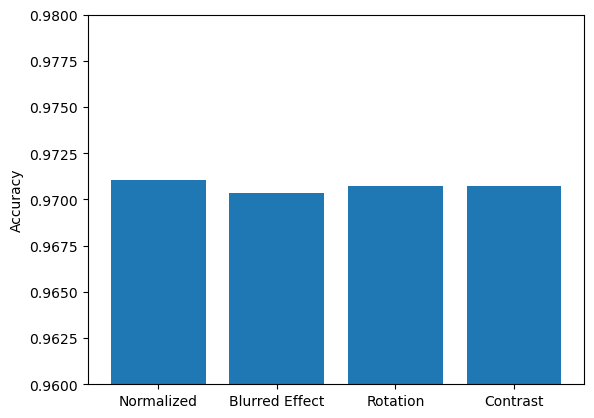

In [44]:
normalized_accuracy = max(Normal_model[1]).item()
blurred_effect_accuracy = max(Blurry_model[1]).item()
rotation_accuracy = max(Rotated_model[1]).item()
contrast_accuracy = max(Constrasted_model[1]).item()

# Create a list of accuracy values
accuracies = [normalized_accuracy, blurred_effect_accuracy, rotation_accuracy, contrast_accuracy]

# Create a list of category names
categories = ['Normalized','Blurred Effect', 'Rotation', 'Contrast']

# Create the bar plot
plt.bar(categories, accuracies)

# Set the Y-axis label to 'Accuracy'
plt.ylabel('Accuracy')

plt.ylim(0.96, 0.98, 0.001)

# Show the plot
plt.show()